# E-commerce Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib import rc

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-colorblind')
rc('font', family='LG PC')

In [2]:
data = pd.read_csv('data.csv', encoding='cp1252')

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# itemID를 품목명으로 전환

* category_dict 생성

In [4]:
sto_des = data[['StockCode', 'Description']]

In [5]:
sto_des.describe()

,StockCode,Description
count,541909,540455
unique,4070,4223
top,85123A,WHITE HANGING HEART T-LIGHT HOLDER
freq,2313,2369


In [6]:
sto_des.drop_duplicates(inplace=True)
sto_des.describe()

,StockCode,Description
count,5752,4792
unique,4070,4223
top,20713,check
freq,9,146


* unique한 StockCode의 수보다 Description이 많다는 것은 한 물품에 여러가지 이름이 존재한다는 것. 이를 빠뜨리지않고 저장해 주어야 한다.

In [7]:
sto_des.isnull().sum()

StockCode        0
Description    960
dtype: int64

* null 값이 다소 존재 하지만 중복이 되면서 다른이름을 가지고 있을 수 있기 때문에 확인해 주어야한다.

In [8]:
from collections import defaultdict

category_dict = defaultdict(list)
for i, j in zip(sto_des['StockCode'], sto_des['Description']):
    category_dict[i].append(j)

In [9]:
len(category_dict.keys())

4070

In [10]:
count = 0
for i in category_dict.values():
    if len(i) == 1 and type(i[0]) is float:
        count += 1
count

112

* nan값은 float값을 가지며 최종적으로 nan값만을 가지고 있는 key(물품)가 몇개가 있는지 알아본 결과 112 개였다.
* dataframe의 null값이 960개를 가진 것과는 다소 차이가 있는 결과이다.

# 고객별 물품 품목 개수

* 고객 별로 물품을 몇개 구입을 하였는지 알아보고 여러가지 rating을 적용해 보는 것이 의미가 있는지, 궁극적으로 추천시스템을 적용할만한 데이터 셋인지 확인해 본다.

In [11]:
dataset = data[['CustomerID', 'StockCode', 'InvoiceNo']]
dataset.columns=['UserID', 'ItemID', 'Order']
dataset.head()

,UserID,ItemID,Order
0,17850.0,85123A,536365
1,17850.0,71053,536365
2,17850.0,84406B,536365
3,17850.0,84029G,536365
4,17850.0,84029E,536365


In [12]:
dataset.isnull().sum()

UserID    135080
ItemID         0
Order          0
dtype: int64

In [13]:
dataset.dropna(inplace=True)

In [14]:
dataset['UserID'] = dataset['UserID'].astype(int).astype(str)
dataset.dtypes

UserID    object
ItemID    object
Order     object
dtype: object

In [15]:
dataset.describe()

,UserID,ItemID,Order
count,406829,406829,406829
unique,4372,3684,22190
top,17841,85123A,576339
freq,7983,2077,542


In [16]:
user_count = dataset.copy()
user_count = user_count[['UserID', 'ItemID']]
user_count.drop_duplicates(inplace=True)

* groupby를 통해 고객별 구매 아이템 수를 확인하려 할 때, (UserID, ItemID)의 중복이 있으면 같은 Item이라도 count를 늘려버리기 때문에 중복을 제거하고 확인해야 한다.

In [17]:
user_count['count'] = user_count.groupby(['UserID'])['ItemID'].transform(np.size)

In [18]:
user_count = user_count[['UserID', 'count']]
user_count.drop_duplicates(inplace=True)
user_count = user_count.reset_index()
user_count.drop(columns=['index'], inplace=True)

In [19]:
user_count.head()

,UserID,count
0,17850,24
1,13047,106
2,12583,115
3,13748,24
4,15100,1


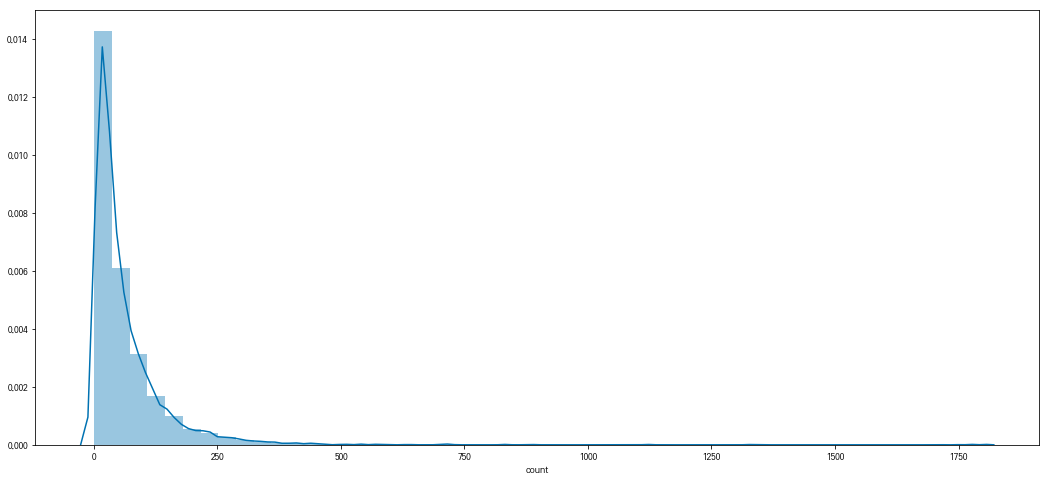

In [21]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 8)

sns.distplot(user_count['count'])

* 유저별 구매한 품목개수의 편차가 너무 심하다 normalization이 필요할 것 같다.

In [22]:
print('물품을 10개 이하로 구매한 고객의 비율: ')
print(user_count[user_count['count'] <= 10]['UserID'].count() / user_count['UserID'].count())

물품을 10개 이하로 구매한 고객의 비율: 
0.16948764867337604


* 편차는 존재하지만 고객별로 비교적 많은 물품을 구매하였다. 1개만 구입한 인원은 별로 없다.

# Binary Ratings

* bin_ratings 생성

In [23]:
bin_ratings = dataset.copy()
bin_ratings = bin_ratings[['UserID', 'ItemID']]
bin_ratings.drop_duplicates(inplace=True)
bin_ratings['ratings'] = 1
bin_ratings.describe(include = 'all')

,UserID,ItemID,ratings
count,267615,267615,267615.0
unique,4372,3684,NaN
top,14911,22423,NaN
freq,1794,887,NaN
mean,NaN,NaN,1.0
std,NaN,NaN,0.0
min,NaN,NaN,1.0
25%,NaN,NaN,1.0
50%,NaN,NaN,1.0
75%,NaN,NaN,1.0


# Frequency & Quant Ratings

* 특정 고객의 특정 물품에 대한 transaction수 + 특정 고객의 특정 물품에 대한 보정치 = ratings

* 특정 고객의 특정 물품에 대한 가중치는 Qunatitiy로 판단. Quantity가 '+' 라면 주문을 더 많이 한 경우. '-'라면 환불을 더 많이 한 경우 0 이라면 단순 실수. Quantity만큼 rating을 보정.

* 주문 한번에 확 샀다가 한번에 확 환불해버리는 경우는 rating이 상당히 낮게 된다. 이는 이대로 좋을 것 같다는 생각이 들었다.

* 빈도수를 정의할 때 주문/반품의 의미를 다르게 둘 것인지, 동일하게 관심이 있는 것으로 볼 것인지, 또 다른 방법으로 처리를 할 것인지는 분석자의 주관에 따른 것 같다. 보다 객관적인 rating을 정할 수 있도록 많은 논의가 필요하다.

* Normalizing 필요.

### 1. Qunat

In [24]:
quant_ratings = data.copy()

In [25]:
quant_ratings = quant_ratings[['CustomerID', 'StockCode', 'InvoiceNo', 'Quantity']]
quant_ratings.columns = ['UserID', 'ItemID', 'OrderID', 'Quantity']
quant_ratings.dropna(inplace=True)
quant_ratings['UserID'] = quant_ratings['UserID'].astype(int).astype(str)

In [26]:
quant_ratings['ratings'] = quant_ratings.groupby(['UserID', 'ItemID'])['Quantity'].transform(np.sum)

In [27]:
quant_ratings = quant_ratings[['UserID', 'ItemID', 'ratings']]
quant_ratings.drop_duplicates(inplace=True)
quant_ratings.describe(include = 'all')

,UserID,ItemID,ratings
count,267615,267615,267615.000000
unique,4372,3684,NaN
top,14911,22423,NaN
freq,1794,887,NaN
mean,NaN,NaN,18.335624
std,NaN,NaN,97.389167
min,NaN,NaN,-9360.000000
25%,NaN,NaN,2.000000
50%,NaN,NaN,6.000000
75%,NaN,NaN,12.000000


### 2. Frequency

In [28]:
freq_ratings = dataset.copy()
freq_ratings.drop_duplicates(inplace=True)

In [29]:
freq_ratings['ratings'] = freq_ratings.groupby(['UserID', 'ItemID'])['Order'].transform(np.size)

In [30]:
freq_ratings = freq_ratings[['UserID', 'ItemID', 'ratings']]
freq_ratings.drop_duplicates(inplace=True)
freq_ratings.describe(include='all')

,UserID,ItemID,ratings
count,267615,267615,267615.000000
unique,4372,3684,NaN
top,14911,22423,NaN
freq,1794,887,NaN
mean,NaN,NaN,1.482282
std,NaN,NaN,1.383156
min,NaN,NaN,1.000000
25%,NaN,NaN,1.000000
50%,NaN,NaN,1.000000
75%,NaN,NaN,1.000000


In [31]:
count_data = freq_ratings['ratings'].value_counts()
count_data = count_data.reset_index()
count_data.columns = ['ratings', 'count']
count_data.head()

,ratings,count
0,1,204131
1,2,37616
2,3,12585
3,4,5502
4,5,2815


In [32]:
print('고객별 물품별 rating이 1인 경우의 비율 :')
print(count_data['count'][0] / count_data['count'].sum())

고객별 물품별 rating이 1인 경우의 비율 :
0.7627786185378249


* rating이 1인 물품의 비율이 크긴하지만 brazillian dataset보다는 고객별로 많은 물품을 구매하였음을 위에서 확인했다. 

### 3. Normalizing

* RobustSclaer, MinMaxScaler 동시에 사용하면 어떻게 될까 이상치를 보완해준 다음 MinMax으로 0에서 1사이의 값으로 mapping. Rating으로 활용하기 위해서는 0에서 1사이의 값이 필요할 것이다.

In [34]:
rating_frame = pd.DataFrame({'freq_rating': freq_ratings['ratings'].values, 'quant_rating': quant_ratings['ratings'].values})

In [35]:
rating_frame.head()

,freq_rating,quant_rating
0,17,122
1,17,122
2,15,108
3,17,110
4,17,104


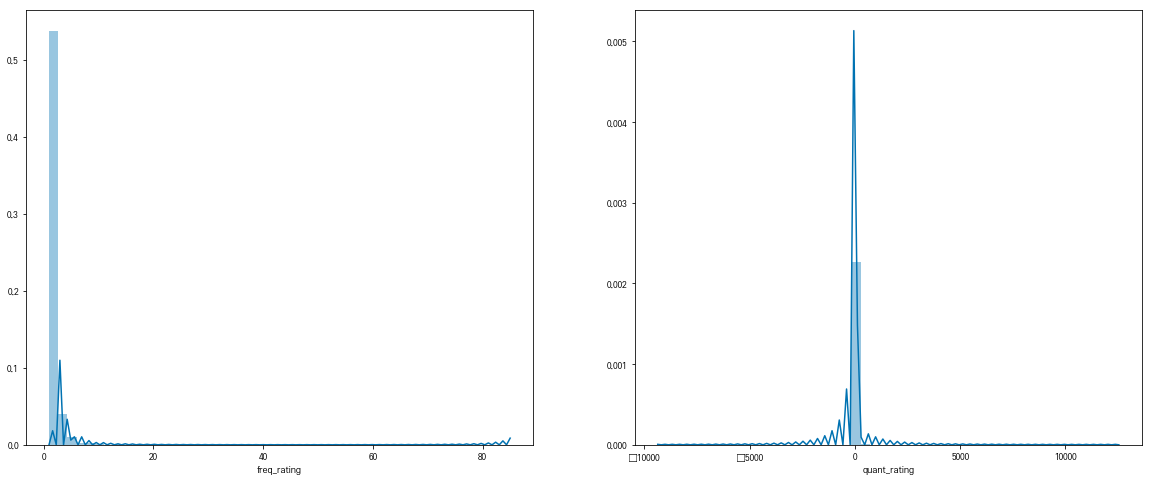

In [51]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(20, 8)

sns.distplot(rating_frame['freq_rating'], ax=ax1)
sns.distplot(rating_frame['quant_rating'], ax=ax2)

In [53]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
min_max_frame = min_max_scaler.fit_transform(rating_frame)
min_max_frame = pd.DataFrame(min_max_frame)
min_max_frame.columns = ['freq_rating', 'quant_rating']
min_max_frame.head()

,freq_rating,quant_rating
0,0.190476,0.432968
1,0.190476,0.432968
2,0.166667,0.432329
3,0.190476,0.432420
4,0.190476,0.432146


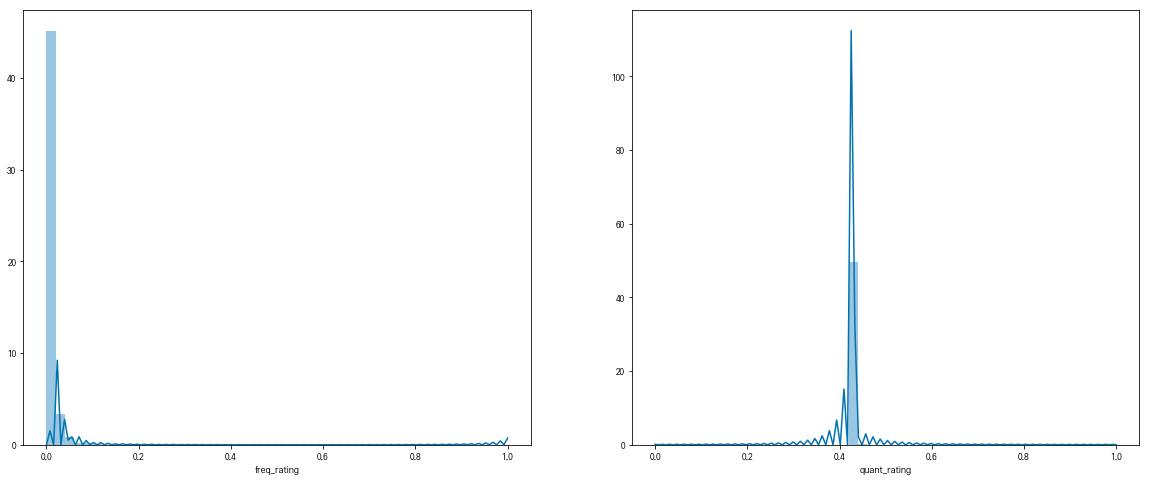

In [54]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(20, 8)

sns.distplot(min_max_frame['freq_rating'], ax=ax1)
sns.distplot(min_max_frame['quant_rating'], ax=ax2)

* RoubstScaler는 중앙값과 IQR에 따라 scaling을 하게 되는데, 특정 값에 치우친 데이터의 경우 큰 변화가 없을 수 있다.

# Collaborative Filtering

In [ ]:
from surprise import KNNBasic
from surprise import Dataset
from surprise import Reader
import heapq
from collections import defaultdict
from operator import itemgetter
from six import iteritems

def item_to_category(top_N):
    result = []
    for i in top_N:
        result.append(category_dict[i])
    return result

def item_based_cf(df, testSubject):
    testSubject = testSubject
    k = '10b'
    reader = Reader(line_format='user item rating')
    data = Dataset.load_from_df(df=df, reader=reader)
    trainSet = data.build_full_trainset()
    sim_options = {'name': 'cosine', 'user_based': False}
    
    model = KNNBasic(sim_options=sim_options)
    model.fit(trainSet)
    simsMatrix = model.compute_similarities()
    
    testUserInnerID = trainSet.to_inner_uid(testSubject)
    testUserRatings = trainSet.ur[testUserInnerID]
    kNeighbors = heapq.nlargest(k, testUserRatings, key=lambda t:t[1])
    
    candidates = defaultdict(float)
    for itemID, rating in kNeighbors:
        similarityRow = simsMatrix[itemID]
        for innerID, score in enumerate(similarityRow):
            candidates[innerID] += score * (rating / 5.0)
    
    # Build a dictionary of stuff the user has already seen
    watched = {}
    for itemID, rating in trainSet.ur[testUserInnerID]:
        watched[itemID] = 1
    
    # Get top-rated items from similar users:
    pos = 0
    result = []
    for itemID, ratingSum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
        if not itemID in watched:
            result.append(trainSet.to_raw_iid(itemID))
            pos += 1
            if (pos > 10):
                break
    return result, item_to_category(result)

* RMSE MAE HITRATE의 비교 binary_rating과의 비교 시각화

# RecommenderMetrics.py

In [1]:
import itertools
from surprise import accuracy
from collections import defaultdict

class RecommenderMetrics:
    
    def MAE(predictions):
        return accuracy.mae(predictions, verbose=False)
    
    def RMSE(predictions):
        return accuracy.rmse(predictions, verbose=False)
    
    def GetTopN(predictions, n=10, minimumRating=4.0):
        topN = defaultdict
        
        for userID, movieID, actualRating, estimatedRating, _ in predictions:
            if (estimatedRating >= minimumRating):
                topN[int(userID)].append((int(movieID), estimatedRating))

        for userID, ratings in topN.items():
            ratings.sort(key=lambda x: x[1], reverse=True)
            topN[int(userID)] = ratings[:n]

        return topN
    
    def HitRate(topNPredicted, leftOutPredictions):
        hits = 0
        total = 0

        # For each left-out rating
        for leftOut in leftOutPredictions:
            userID = leftOut[0]
            leftOutMovieID = leftOut[1]
            # Is it in the predicted top 10 for this user?
            hit = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutMovieID) == int(movieID)):
                    hit = True
                    break
            if (hit) :
                hits += 1

            total += 1

        # Compute overall precision
        return hits/total

# EvaluationData.py

In [2]:
from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from surprise import KNNBaseline


class EvaluationData:
    
    def __init__(self, data, popularityRankings):
        
        self.rankings = popularityRankings
        
        #Build a full training set for evaluating overall properties
        self.fullTrainSet = data.build_full_trainset()
        self.fullAntiTestSet = self.fullTrainSet.build_anti_testset()
        
        #Build a 75/25 train/test split for measuring accuracy
        self.trainSet, self.testSet = train_test_split(data, test_size=.25, random_state=1)
        
        #Build a "leave one out" train/test split for evaluating top-N recommenders
        #And build an anti-test-set for building predictions
        LOOCV = LeaveOneOut(n_splits=1, random_state=1)
        for train, test in LOOCV.split(data):
            self.LOOCVTrain = train
            self.LOOCVTest = test
            
        self.LOOCVAntiTestSet = self.LOOCVTrain.build_anti_testset()
        
        #Compute similarty matrix between items so we can measure diversity
        sim_options = {'name': 'cosine', 'user_based': False}
        self.simsAlgo = KNNBaseline(sim_options=sim_options)
        self.simsAlgo.fit(self.fullTrainSet)
            
    def GetFullTrainSet(self):
        return self.fullTrainSet
    
    def GetFullAntiTestSet(self):
        return self.fullAntiTestSet
    
    def GetAntiTestSetForUser(self, testSubject):
        trainset = self.fullTrainSet
        fill = trainset.global_mean
        anti_testset = []
        u = trainset.to_inner_uid(str(testSubject))
        user_items = set([j for (j, _) in trainset.ur[u]])
        anti_testset += [(trainset.to_raw_uid(u), trainset.to_raw_iid(i), fill) for
                                 i in trainset.all_items() if
                                 i not in user_items]
        return anti_testset

    def GetTrainSet(self):
        return self.trainSet
    
    def GetTestSet(self):
        return self.testSet
    
    def GetLOOCVTrainSet(self):
        return self.LOOCVTrain
    
    def GetLOOCVTestSet(self):
        return self.LOOCVTest
    
    def GetLOOCVAntiTestSet(self):
        return self.LOOCVAntiTestSet
    
    def GetSimilarities(self):
        return self.simsAlgo
    
    def GetPopularityRankings(self):
        return self.rankings

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed May  9 10:10:04 2018

@author: Frank
"""

from MovieLens import MovieLens
from surprise import KNNBasic
import heapq
from collections import defaultdict
from operator import itemgetter
        
testSubject = '85'
k = 10

# Load our data set and compute the user similarity matrix
ml = MovieLens()
data = ml.loadMovieLensLatestSmall()

trainSet = data.build_full_trainset()

sim_options = {'name': 'cosine',
               'user_based': True
               }

model = KNNBasic(sim_options=sim_options)
model.fit(trainSet)
simsMatrix = model.compute_similarities()

# Get top N similar users to our test subject
# (Alternate approach would be to select users up to some similarity threshold - try it!)
testUserInnerID = trainSet.to_inner_uid(testSubject)
similarityRow = simsMatrix[testUserInnerID]

similarUsers = []
for innerID, score in enumerate(similarityRow):
    if (innerID != testUserInnerID):
        similarUsers.append((innerID, score))

kNeighbors = heapq.nlargest(k, similarUsers, key=lambda t: t[1])

# Tuning Collaborative Filtering Algorithms
# kNeighbors = []
# for rating in similarUsers:
#   if rating[1] > 0.95:
#       kNeighbors.append(rating)

# Get the stuff they rated, and add up ratings for each item, weighted by user similarity
candidates = defaultdict(float)
for similarUser in kNeighbors:
    innerID = similarUser[0]
    userSimilarityScore = similarUser[1]
    theirRatings = trainSet.ur[innerID]
    for rating in theirRatings:
        candidates[rating[0]] += (rating[1] / 5.0) * userSimilarityScore
    
# Build a dictionary of stuff the user has already seen
watched = {}
for itemID, rating in trainSet.ur[testUserInnerID]:
    watched[itemID] = 1
    
# Get top-rated items from similar users:
pos = 0
for itemID, ratingSum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
    if not itemID in watched:
        movieID = trainSet.to_raw_iid(itemID)
        print(ml.getMovieName(int(movieID)), ratingSum)
        pos += 1
        if (pos > 10):
            break

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed May  9 10:10:04 2018

@author: Frank
"""
from MovieLens import MovieLens
from surprise import KNNBasic
import heapq
from collections import defaultdict
from operator import itemgetter
from surprise.model_selection import LeaveOneOut
from RecommenderMetrics import RecommenderMetrics
from EvaluationData import EvaluationData

def LoadMovieLensData():
    ml = MovieLens()
    print("Loading movie ratings...")
    data = ml.loadMovieLensLatestSmall()
    print("\nComputing movie popularity ranks so we can measure novelty later...")
    rankings = ml.getPopularityRanks()
    return (ml, data, rankings)

ml, data, rankings = LoadMovieLensData()

evalData = EvaluationData(data, rankings)

# Train on leave-One-Out train set
trainSet = evalData.GetLOOCVTrainSet()
sim_options = {'name': 'cosine',
               'user_based': True
               }

model = KNNBasic(sim_options=sim_options)
model.fit(trainSet)
simsMatrix = model.compute_similarities()

leftOutTestSet = evalData.GetLOOCVTestSet()

# Build up dict to lists of (int(movieID), predictedrating) pairs
topN = defaultdict(list)
k = 10
for uiid in range(trainSet.n_users):
    # Get top N similar users to this one
    similarityRow = simsMatrix[uiid]
    
    similarUsers = []
    for innerID, score in enumerate(similarityRow):
        if (innerID != uiid):
            similarUsers.append( (innerID, score) )
    
    kNeighbors = heapq.nlargest(k, similarUsers, key=lambda t: t[1])
    
    # Get the stuff they rated, and add up ratings for each item, weighted by user similarity
    candidates = defaultdict(float)
    for similarUser in kNeighbors:
        innerID = similarUser[0]
        userSimilarityScore = similarUser[1]
        theirRatings = trainSet.ur[innerID]
        for rating in theirRatings:
            candidates[rating[0]] += (rating[1] / 5.0) * userSimilarityScore
        
    # Build a dictionary of stuff the user has already seen
    watched = {}
    for itemID, rating in trainSet.ur[uiid]:
        watched[itemID] = 1
        
    # Get top-rated items from similar users:
    pos = 0
    for itemID, ratingSum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
        if not itemID in watched:
            movieID = trainSet.to_raw_iid(itemID)
            topN[int(trainSet.to_raw_uid(uiid))].append( (int(movieID), 0.0) )
            pos += 1
            if (pos > 40):
                break
    
# Measure
print("HR", RecommenderMetrics.HitRate(topN, leftOutTestSet))   


